In [1]:
import numpy as np
import pandas as pd
from collections import defaultdict
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import squareform
from skbio.stats.ordination import pcoa
from skbio.stats.distance import permanova
from scipy.stats import ttest_ind
import matplotlib.colors as mcolors
from skbio import DistanceMatrix
import matplotlib.pyplot as plt
import seaborn as sns

/home/bostevens/anaconda3/envs/py311/lib/python3.11/site-packages/numpy/core/getlimits.py:542: UserWarning: Signature b'\x00\xd0\xcc\xcc\xcc\xcc\xcc\xcc\xfb\xbf\x00\x00\x00\x00\x00\x00' for <class 'numpy.longdouble'> does not match any known type: falling back to type probe function.
This warnings indicates broken support for the dtype!
  machar = _get_machar(dtype)


In [2]:
its = pd.read_csv('EMU.ITS.rel_abund.final.csv').fillna(0)
bacteria = pd.read_csv('EMU.16S.rel_abund.final.csv').fillna(0)
amf = pd.read_csv('EMU.18S.rel_abund.final.csv').fillna(0)
env_data = pd.read_csv('env_data.csv')

In [3]:
env_data.head()

,sample_id,litter,decomp,soilP,om,Treatment
0,1,2.330,0.670,12.008,1.4282,BOTGRA
1,2,2.780,0.220,11.987,3.1420,BROTEC
2,3,2.255,0.745,11.831,1.0861,BOTGRA
3,4,1.475,1.525,12.638,1.8493,BOTGRA
4,5,2.175,0.825,12.354,0.9445,BOTGRA


In [4]:
amf.head()

,superkingdom,phylum,class,order,family,genus,species,tax_id,1,2,...,11,12,13,14,15,16,17,18,19,20
0,Fungi,Glomeromycota,Glomeromycetes,Diversisporales,Acaulosporaceae,Acaulospora,Acaulospora brasiliensis,106.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.039427,0.040975,0.054168,0.052205,0.041015,0.000000,0.044831
1,Fungi,Glomeromycota,Glomeromycetes,Glomerales,Claroideoglomeraceae,Claroideoglomus,Claroideoglomus drummondii,97.0,0.023238,0.030699,...,0.030549,0.040467,0.010632,0.028334,0.000000,0.059979,0.045987,0.050463,0.019567,0.044734
2,Fungi,Glomeromycota,Glomeromycetes,Glomerales,Claroideoglomeraceae,Claroideoglomus,Claroideoglomus sp. 1,54.0,0.048086,0.005693,...,0.000000,0.018674,0.036252,0.038080,0.000000,0.019703,0.024705,0.008324,0.057529,0.054809
3,Fungi,Glomeromycota,Glomeromycetes,Glomerales,Claroideoglomeraceae,Claroideoglomus,Claroideoglomus sp. 2,215.0,0.005731,0.000000,...,0.020243,0.052205,0.044202,0.026663,0.035953,0.029571,0.061115,0.023234,0.009606,0.024312
4,Fungi,Glomeromycota,Glomeromycetes,Glomerales,Claroideoglomeraceae,Claroideoglomus,Claroideoglomus sp. 3,240.0,0.076448,0.067670,...,0.005066,0.000000,0.007767,0.027921,0.000000,0.051891,0.047580,0.051383,0.020346,0.010382


In [20]:
set(amf['genus'])

{0,
 'Acaulospora',
 'Claroideoglomus',
 'Diversispora',
 'Dominikia',
 'Funneliformis',
 'Geosiphon',
 'Gigaspora',
 'Kamienskia',
 'Paraglomus',
 'Rhizophagus ',
 'Sclerocystis',
 'UNK'}

In [14]:
def perform_ttest_on_genus(amf_df, env_data_df, target_genus):
    """
    Perform a t-test on a specific family in the 'amf' dataframe, grouped by the 'Treatment' column in the 'evn_data' dataframe.
    """
    # Filter the columns of interest in the 'amf' dataframe
    columns_to_keep = ['genus', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20']
    filtered_amf_df = amf_df[columns_to_keep].copy()
    
    # Convert to numeric if necessary
    for col in columns_to_keep[1:]:
        filtered_amf_df[col] = pd.to_numeric(filtered_amf_df[col], errors='coerce')
    
    # Group by the target genus and sum the values
    grouped_amf_df = filtered_amf_df[filtered_amf_df['genus'] == target_genus].groupby('genus').sum()
    
    # Convert the summed values to a list
    summed_values_list = grouped_amf_df.iloc[0].tolist()
    
    # Get the 'Treatment' column values from the 'evn_data' dataframe
    treatment_values = env_data_df['Treatment'].tolist()
    
    # Group summed_values_list by treatment_values
    treatment_dict = defaultdict(list)
    for t, val in zip(treatment_values, summed_values_list):
        treatment_dict[t].append(val)
    
    # Assuming you have exactly two treatment groups, perform the t-test
    if len(treatment_dict.keys()) != 2:
        return "There must be exactly two treatment groups for a two-sample t-test.", None
    
    group1, group2 = treatment_dict.values()
    
    t_statistic, p_value = ttest_ind(group1, group2)
    
    return t_statistic, p_value

In [32]:
def generate_ttest_table(amf_df, env_data_df, genera_list):
    """
    Generate a table of t-statistics and p-values for a list of genera.
    """
    # Create an empty DataFrame to store the results
    ttest_table = pd.DataFrame(columns=['Genus', 'T-statistic', 'P-value'])

    # Iterate through each genus in the list
    for genus in genera_list:
        t_statistic, p_value = perform_ttest_on_genus(amf_df, env_data_df, genus)
        
        # If the t-test was performed successfully, append the results to the DataFrame
        if p_value is not None:
            new_row = pd.DataFrame({'Genus': [genus], 
                                    'T-statistic': [t_statistic], 
                                    'P-value': [p_value]})
            ttest_table = pd.concat([ttest_table, new_row], ignore_index=True)
        else:
            print(f"Failed to perform t-test on genus {genus}: {t_statistic}")
    
    return ttest_table

In [33]:
# List of genera
genera_list = ['Acaulospora', 'Claroideoglomus', 'Diversispora', 'Dominikia', 'Funneliformis', 
               'Geosiphon', 'Gigaspora', 'Kamienskia', 'Paraglomus', 'Rhizophagus ', 'Sclerocystis']

# Assuming amf and env_data are your dataframes
ttest_table = generate_ttest_table(amf, env_data, genera_list)

# To display the table
print(ttest_table)

# To save the table to a CSV file
ttest_table.to_csv('ttest_table.csv', index=False)

              Genus  T-statistic   P-value
0       Acaulospora    -3.602955  0.002034
1   Claroideoglomus     1.686910  0.108874
2      Diversispora     3.117461  0.005948
3         Dominikia     2.508345  0.021924
4     Funneliformis     0.406545  0.689135
5         Geosiphon     0.007291  0.994263
6         Gigaspora    -1.280446  0.216643
7        Kamienskia    -0.942416  0.358457
8        Paraglomus    -2.028172  0.057606
9      Rhizophagus     -5.075927  0.000079
10     Sclerocystis    -0.538748  0.596662


/tmp/ipykernel_5558/3064154743.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  ttest_table = pd.concat([ttest_table, new_row], ignore_index=True)


# PERMANOVAs

In [24]:
# Step 1: Convert the 'sample_id' in env_data to a list of strings
sample_ids = env_data['sample_id'].astype(str).tolist()

# Step 2: Filter the microbial dataframes to keep only those columns that match the sample_ids
its_filtered = its[sample_ids].fillna(0).T
bacteria_filtered = bacteria[sample_ids].fillna(0).T
amf_filtered = amf[sample_ids].fillna(0).T

In [25]:
amf_filtered.head()

,0,1,2,3,4,5,6,7,8,9,...,29,30,31,32,33,34,35,36,37,38
1,0.0,0.023238,0.048086,0.005731,0.076448,0.034915,0.0,0.084136,0.075266,0.078899,...,0.004993,0.019467,0.000679,0.007315,0.011760,0.012762,0.005739,0.019454,0.000000,0.000000
2,0.0,0.030699,0.005693,0.000000,0.067670,0.000000,0.0,0.053985,0.000000,0.063116,...,0.035400,0.001686,0.074215,0.086541,0.064590,0.019429,0.003950,0.018456,0.005258,0.000362
3,0.0,0.076340,0.010694,0.081981,0.002508,0.064642,0.0,0.066557,0.041043,0.056229,...,0.004787,0.003234,0.002542,0.007076,0.000000,0.004534,0.013724,0.013970,0.005256,0.002714
4,0.0,0.001736,0.065591,0.067460,0.059729,0.048844,0.0,0.095436,0.090377,0.066978,...,0.019202,0.009195,0.007998,0.004949,0.000515,0.010987,0.015138,-0.029683,0.004644,0.018114
5,0.0,0.065006,0.060668,0.046050,0.025754,0.084644,0.0,0.024811,0.071611,0.024536,...,0.017321,0.000166,0.005938,0.005810,0.006501,0.003739,0.018632,-0.122592,0.016170,0.010128


In [26]:
def calculate_permanova_and_pcoa(df, treatment_data):
    # Convert DataFrame to Numpy array
    df_np = df.to_numpy()
    
    # Calculate distance matrices
    bray_curtis_dm_np = pairwise_distances(df_np, metric='braycurtis')
    jaccard_dm_np = pairwise_distances(df_np, metric='jaccard')
    
    # Convert Numpy arrays to skbio.DistanceMatrix objects
    bray_curtis_dm = DistanceMatrix(bray_curtis_dm_np, ids=df.index)
    jaccard_dm = DistanceMatrix(jaccard_dm_np, ids=df.index)
    
    # Run PERMANOVA tests
    perma_bray = permanova(bray_curtis_dm, treatment_data)
    perma_jacc = permanova(jaccard_dm, treatment_data)
    
    # Perform PCoA
    pcoa_bray = pcoa(bray_curtis_dm)
    pcoa_jacc = pcoa(jaccard_dm)
    
    return (pcoa_bray, pcoa_jacc), (perma_bray, perma_jacc)

/home/bostevens/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/home/bostevens/anaconda3/envs/py311/lib/python3.11/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:143: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -6.422056212933857e-05 and the largest is 0.9675555982546316.
  warn(
/home/bostevens/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/home/bostevens/

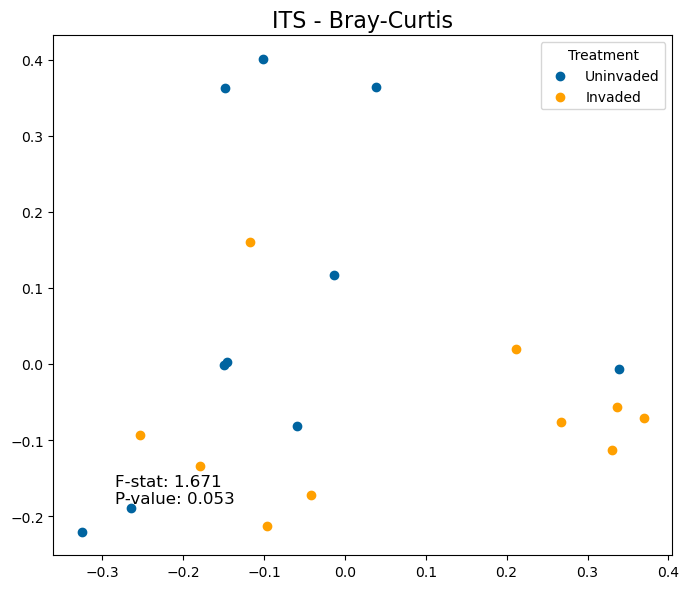

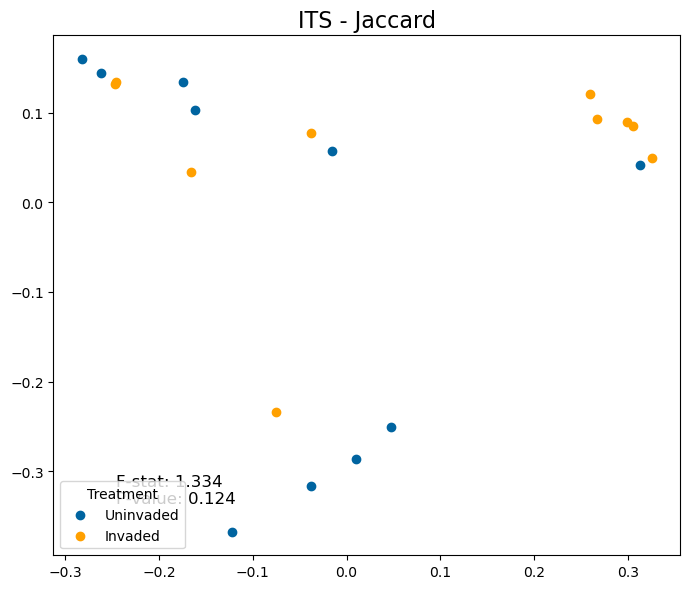

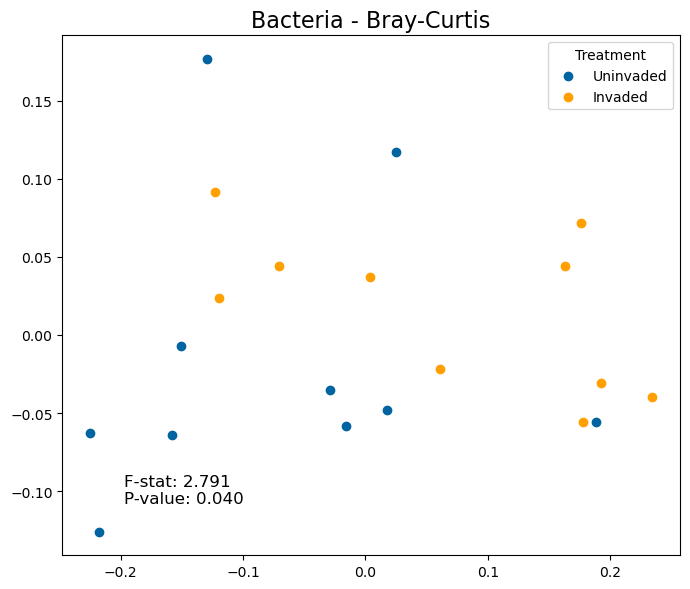

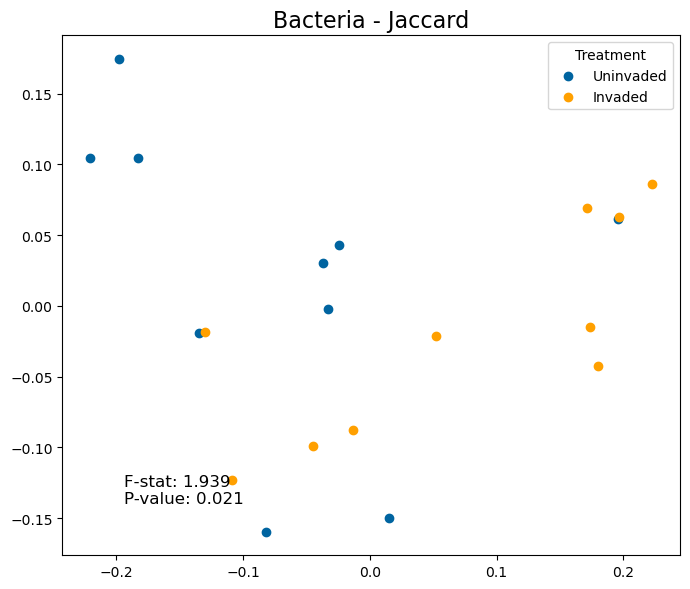

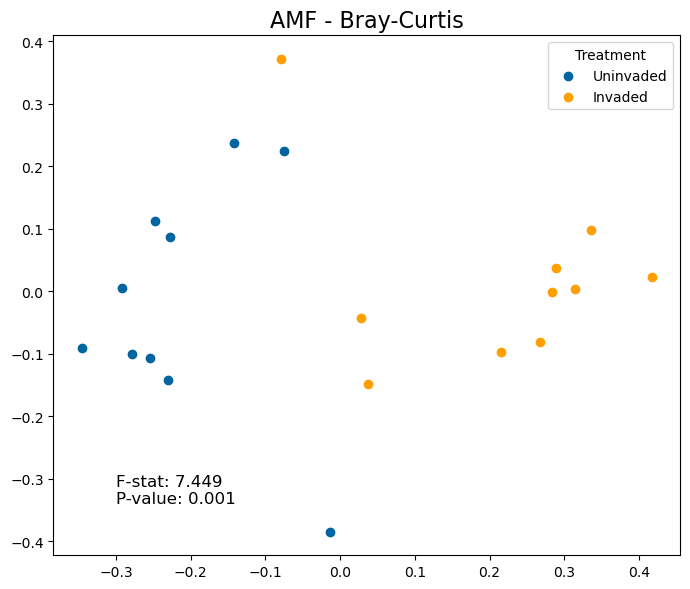

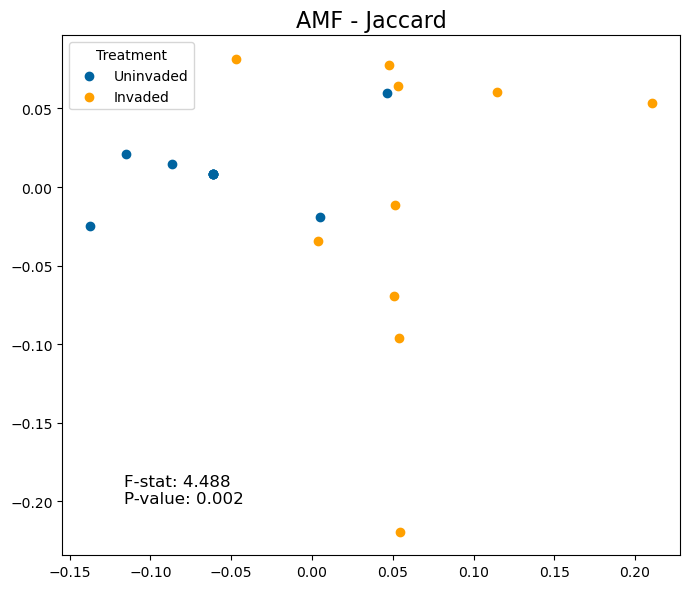

In [28]:
# Calculate permanova and pcoa for the three communities
its_results = calculate_permanova_and_pcoa(its_filtered, treatment_data)
bacteria_results = calculate_permanova_and_pcoa(bacteria_filtered, treatment_data)
amf_results = calculate_permanova_and_pcoa(amf_filtered, treatment_data)

# List of titles
titles = ['ITS', 'Bacteria', 'AMF']

# Loop over results and titles to populate the plots
for idx, (res, title) in enumerate(zip([its_results, bacteria_results, amf_results], titles)):
    (pcoa_bray, pcoa_jacc), (perma_bray, perma_jacc) = res
    
    # Reset index for ordination data
    pcoa_bray.samples.reset_index(drop=True, inplace=True)
    pcoa_jacc.samples.reset_index(drop=True, inplace=True)
    
    for distance_name, (pcoa_result, perma_result) in zip(['Bray-Curtis', 'Jaccard'], [(pcoa_bray, perma_bray), (pcoa_jacc, perma_jacc)]):
        plt.figure(figsize=(7, 6))
        ax = plt.gca()
        
        for treatment in unique_treatments:
            mask = treatment_data == treatment
            ax.scatter(x=pcoa_result.samples.loc[mask].iloc[:, 0], 
                       y=pcoa_result.samples.loc[mask].iloc[:, 1], 
                       color=color_map[treatment],
                       label=treatment)
        
        ax.legend(title='Treatment')
        ax.set_title(f'{title} - {distance_name}', fontsize=16)
        ax.annotate(f"F-stat: {perma_result['test statistic']:.3f}\nP-value: {perma_result['p-value']:.3f}", 
                    xy=(0.1, 0.1), xycoords='axes fraction', fontsize=12)
        
        plt.tight_layout()
        plt.savefig(f'ordination_permanova_{title}_{distance_name}.pdf', bbox_inches='tight', dpi=300)
